In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-10-30 14:05:08.465371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 14:05:08.589274: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 14:05:08.594129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-30 14:05:08.594147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

# Load Data

In [2]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]

print(f"{df.shape=}")
df = df.drop(mt_genes)
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")


df.head()

df.shape=(19393, 18)
df.shape=(19380, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19380


/tmp/ipykernel_2919159/3994445759.py:21: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(gene_path, gene_names)


gf.shape=(19380, 2)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TPM Threshold and full-rank DMD 

In [3]:
rank = 14
target = 1e6
tpm = nb.TPM(df, gf, target=target)

tpm_dist = tpm.mean(axis=1)

results = {}

for i, t in enumerate(np.arange(0, 10, 0.5)):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    
    d = tpm[tpm.index.isin(high_exp_genes)]
    
    dmd_data = nb.data2DMD(d) # coverts to FC
    print(f"{t=} {dmd_data.shape=}")

    dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)
    results[t] = dmd_res.copy()

print('done')

t=0.0 dmd_data.shape=(16361, 8, 2)
t=0.5 dmd_data.shape=(8137, 8, 2)
t=1.0 dmd_data.shape=(6368, 8, 2)
t=1.5 dmd_data.shape=(5271, 8, 2)
t=2.0 dmd_data.shape=(4514, 8, 2)
t=2.5 dmd_data.shape=(3889, 8, 2)
t=3.0 dmd_data.shape=(3402, 8, 2)
t=3.5 dmd_data.shape=(3020, 8, 2)
t=4.0 dmd_data.shape=(2679, 8, 2)
t=4.5 dmd_data.shape=(2399, 8, 2)
t=5.0 dmd_data.shape=(2167, 8, 2)
t=5.5 dmd_data.shape=(1975, 8, 2)
t=6.0 dmd_data.shape=(1803, 8, 2)
t=6.5 dmd_data.shape=(1649, 8, 2)
t=7.0 dmd_data.shape=(1535, 8, 2)
t=7.5 dmd_data.shape=(1434, 8, 2)
t=8.0 dmd_data.shape=(1343, 8, 2)
t=8.5 dmd_data.shape=(1271, 8, 2)
t=9.0 dmd_data.shape=(1184, 8, 2)
t=9.5 dmd_data.shape=(1124, 8, 2)
done


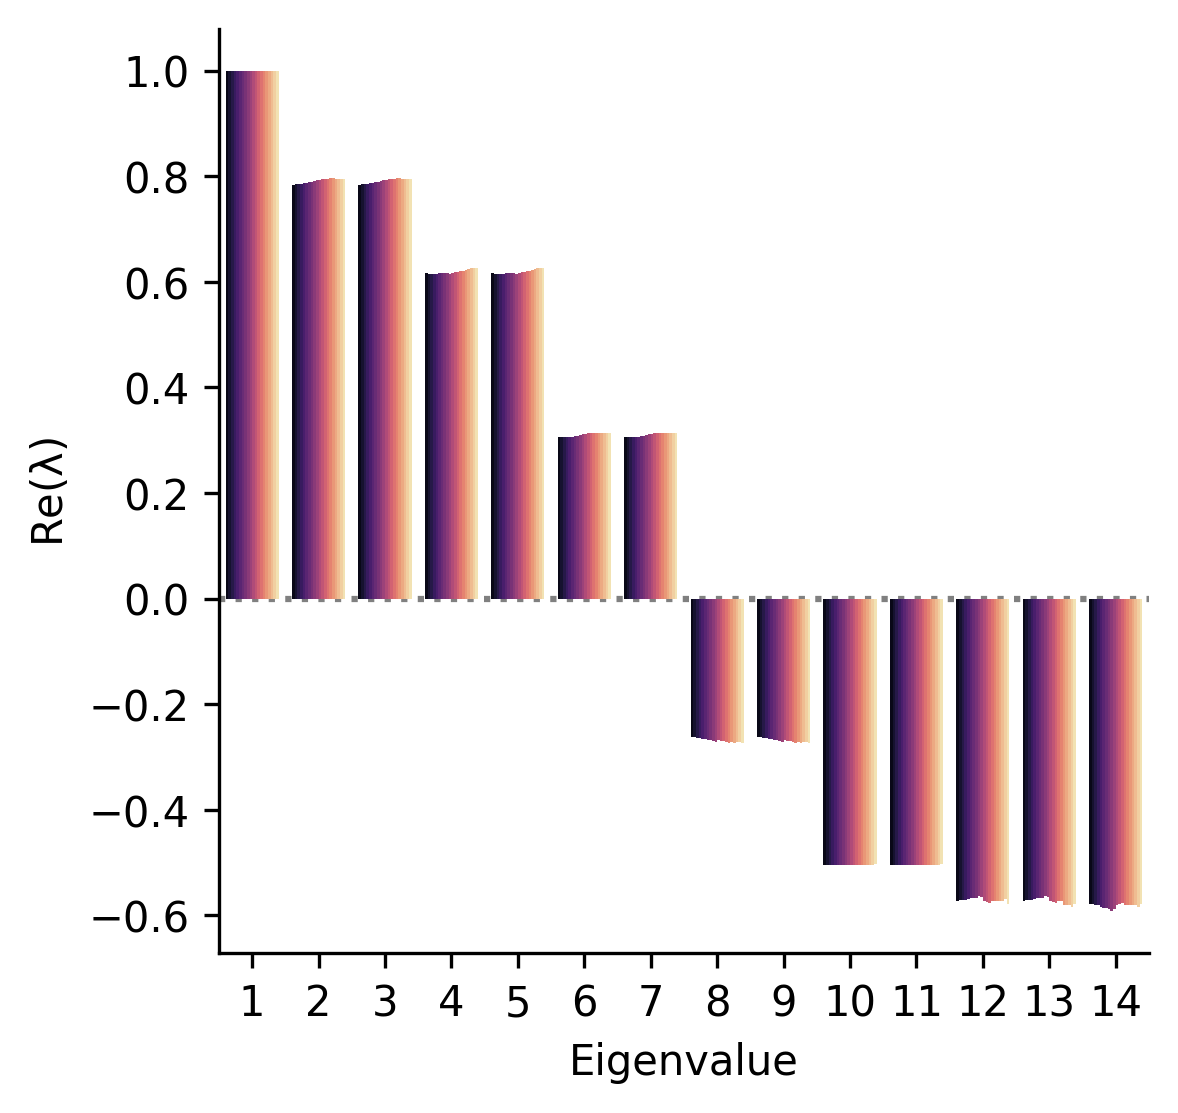

In [4]:

res = []

for i, (threshold, dmd_res) in enumerate(results.items()):
    L = dmd_res['L']
    idx = L.argsort()[::-1]   
    L = L[idx]
    
    pdf = pd.DataFrame({'real' : np.real(L),
                       'imaginary' : np.imag(L)})
    pdf['threshold'] = threshold
    pdf['ord'] = list(range(1, len(L) + 1))
    

    res.append(pdf)

res = pd.concat(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.barplot(data=res, 
             x='ord',
             y='real',
             hue='threshold',
             palette='magma',
             )

plt.axhline(y=0, ls=":", c='grey', zorder=0)
plt.xlabel(r'Eigenvalue')
plt.ylabel(r'$\mathregular{Re(\lambda)}$')
sns.despine()

plt.gca().legend().remove()
plt.show()

# sns.move_legend(plt.gca(),
#                 title='TPM Threshold',
#                 loc='upper right',
#                 frameon=False, 
#                 bbox_to_anchor=(1, 1))

# ut.makeColorbar('magma', 0.2, 2.5, 'TPM Threshold', 'vertical', ['0', '20'])


In [5]:
# break

In [6]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 10, 10

# fig, axs = plt.subplots(4, 5)
# axs = axs.ravel()

# for i, (threshold, dmd_res) in enumerate(results.items()):

#     A = dmd_res['Atilde']
#     sns.heatmap(A, 
#                 square=True,
#                 cmap='RdYlGn', # red is small 
#                 cbar=False,
#                 vmin=-3,
#                 vmax=3,
#                 lw=0.1,
#                 # annot=True, 
#                 # fmt=".1f",
#                 # annot_kws={'fontsize' : 5},
#                 ax=axs[i])
    
#     axs[i].set_title(f"TPM > {threshold}")
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])

# plt.tight_layout()

In [7]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 10

# fig, axs = plt.subplots(4, 5, sharey=True, sharex=True)
# axs = axs.ravel()

# for i, (threshold, dmd_res) in enumerate(results.items()):

#     L = dmd_res['L']
#     idx = L.argsort()[::-1]   
#     L = L[idx]
    
#     axs[i].plot(L, 
#                 lw=1, 
#                 c='k', 
#                 marker=".")

#     axs[i].axhline(y=0, ls=":", c='grey', zorder=0)
#     axs[i].set_title(f"TPM > {threshold}")
#     axs[i].set_xlabel(r'Eigenvalue')
#     axs[i].set_ylabel(r'$\mathregular{Re(\lambda)}$')

# plt.tight_layout()

In [8]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 10

# fig, axs = plt.subplots(4, 5)
# axs = axs.ravel()

# for i, (threshold, dmd_res) in enumerate(results.items()):

#     L = dmd_res['L']

#     # make the unit circle
#     axs[i].plot(np.cos(np.linspace(0, np.pi*2, 100)), 
#                 np.sin(np.linspace(0, np.pi*2, 100)), 
#                 linewidth=1, 
#                 c='k',
#                 zorder=1)

#     # add the axis
#     axs[i].axvline(x=0, ls=":", c='grey', zorder=0)
#     axs[i].axhline(y=0, ls=":", c='grey', zorder=0)

#     pdf = pd.DataFrame({'real' : np.real(L),
#                         'imaginary' : np.imag(L)})


#     # plot the eigenvalues
#     sns.scatterplot(data=pdf,
#                     x='real', 
#                     y='imaginary',
#                     s=100,
#                     marker=".",
#                     c='r',
#                     ec='k',
#                     ax=axs[i],
#                     zorder=3)

#     axs[i].set_aspect('equal')
#     axs[i].set_title(f"TPM > {threshold}")
#     axs[i].set_xlabel(r'$\mathregular{Re(\lambda)}$')
#     axs[i].set_ylabel(r'$\mathregular{Im(\lambda)}$')

# plt.tight_layout()

# choose a TPM threshold

In [9]:
target = 1e6
threshold = 0.5
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
high_exp_genes = tpm_dist[(tpm_dist > threshold)].index.to_list()    

percent_kept = len(high_exp_genes) / len(tpm_dist)
print(f"{percent_kept=}")

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

results = {}

for i, rank in enumerate(np.arange(1, 11, 1)):
    print(f"{rank=}")
    dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)
    results[rank] = dmd_res.copy()

print('done')

percent_kept=0.4198658410732714
dmd_data.shape=(8137, 8, 2)
rank=1
rank=2
rank=3
rank=4
rank=5
rank=6
rank=7
rank=8
rank=9
rank=10
done


In [10]:

# res = []

# for i, (rank, dmd_res) in enumerate(results.items()):
#     L = dmd_res['L']
#     idx = L.argsort()[::-1]   
#     L = L[idx]
    
#     pdf = pd.DataFrame({'real' : np.real(L),
#                        'imaginary' : np.imag(L)})
#     pdf['rank'] = rank
#     pdf['ord'] = list(range(1, len(L) + 1))
    

#     res.append(pdf)

# res = pd.concat(res)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 4

# sns.barplot(data=res, 
#              x='ord',
#              y='real',
#              hue='rank',
#              palette='magma',
#              )

# plt.axhline(y=0, ls=":", c='grey', zorder=0)
# plt.xlabel(r'Eigenvalue')
# plt.ylabel(r'$\mathregular{Re(\lambda)}$')
# sns.despine()

# plt.gca().legend().remove()
# plt.show()

# # sns.move_legend(plt.gca(),
# #                 title='TPM Threshold',
# #                 loc='upper right',
# #                 frameon=False, 
# #                 bbox_to_anchor=(1, 1))

# ut.makeColorbar('magma', 0.2, 2.5, 'SVD Rank', 'vertical', ['1', '14'])


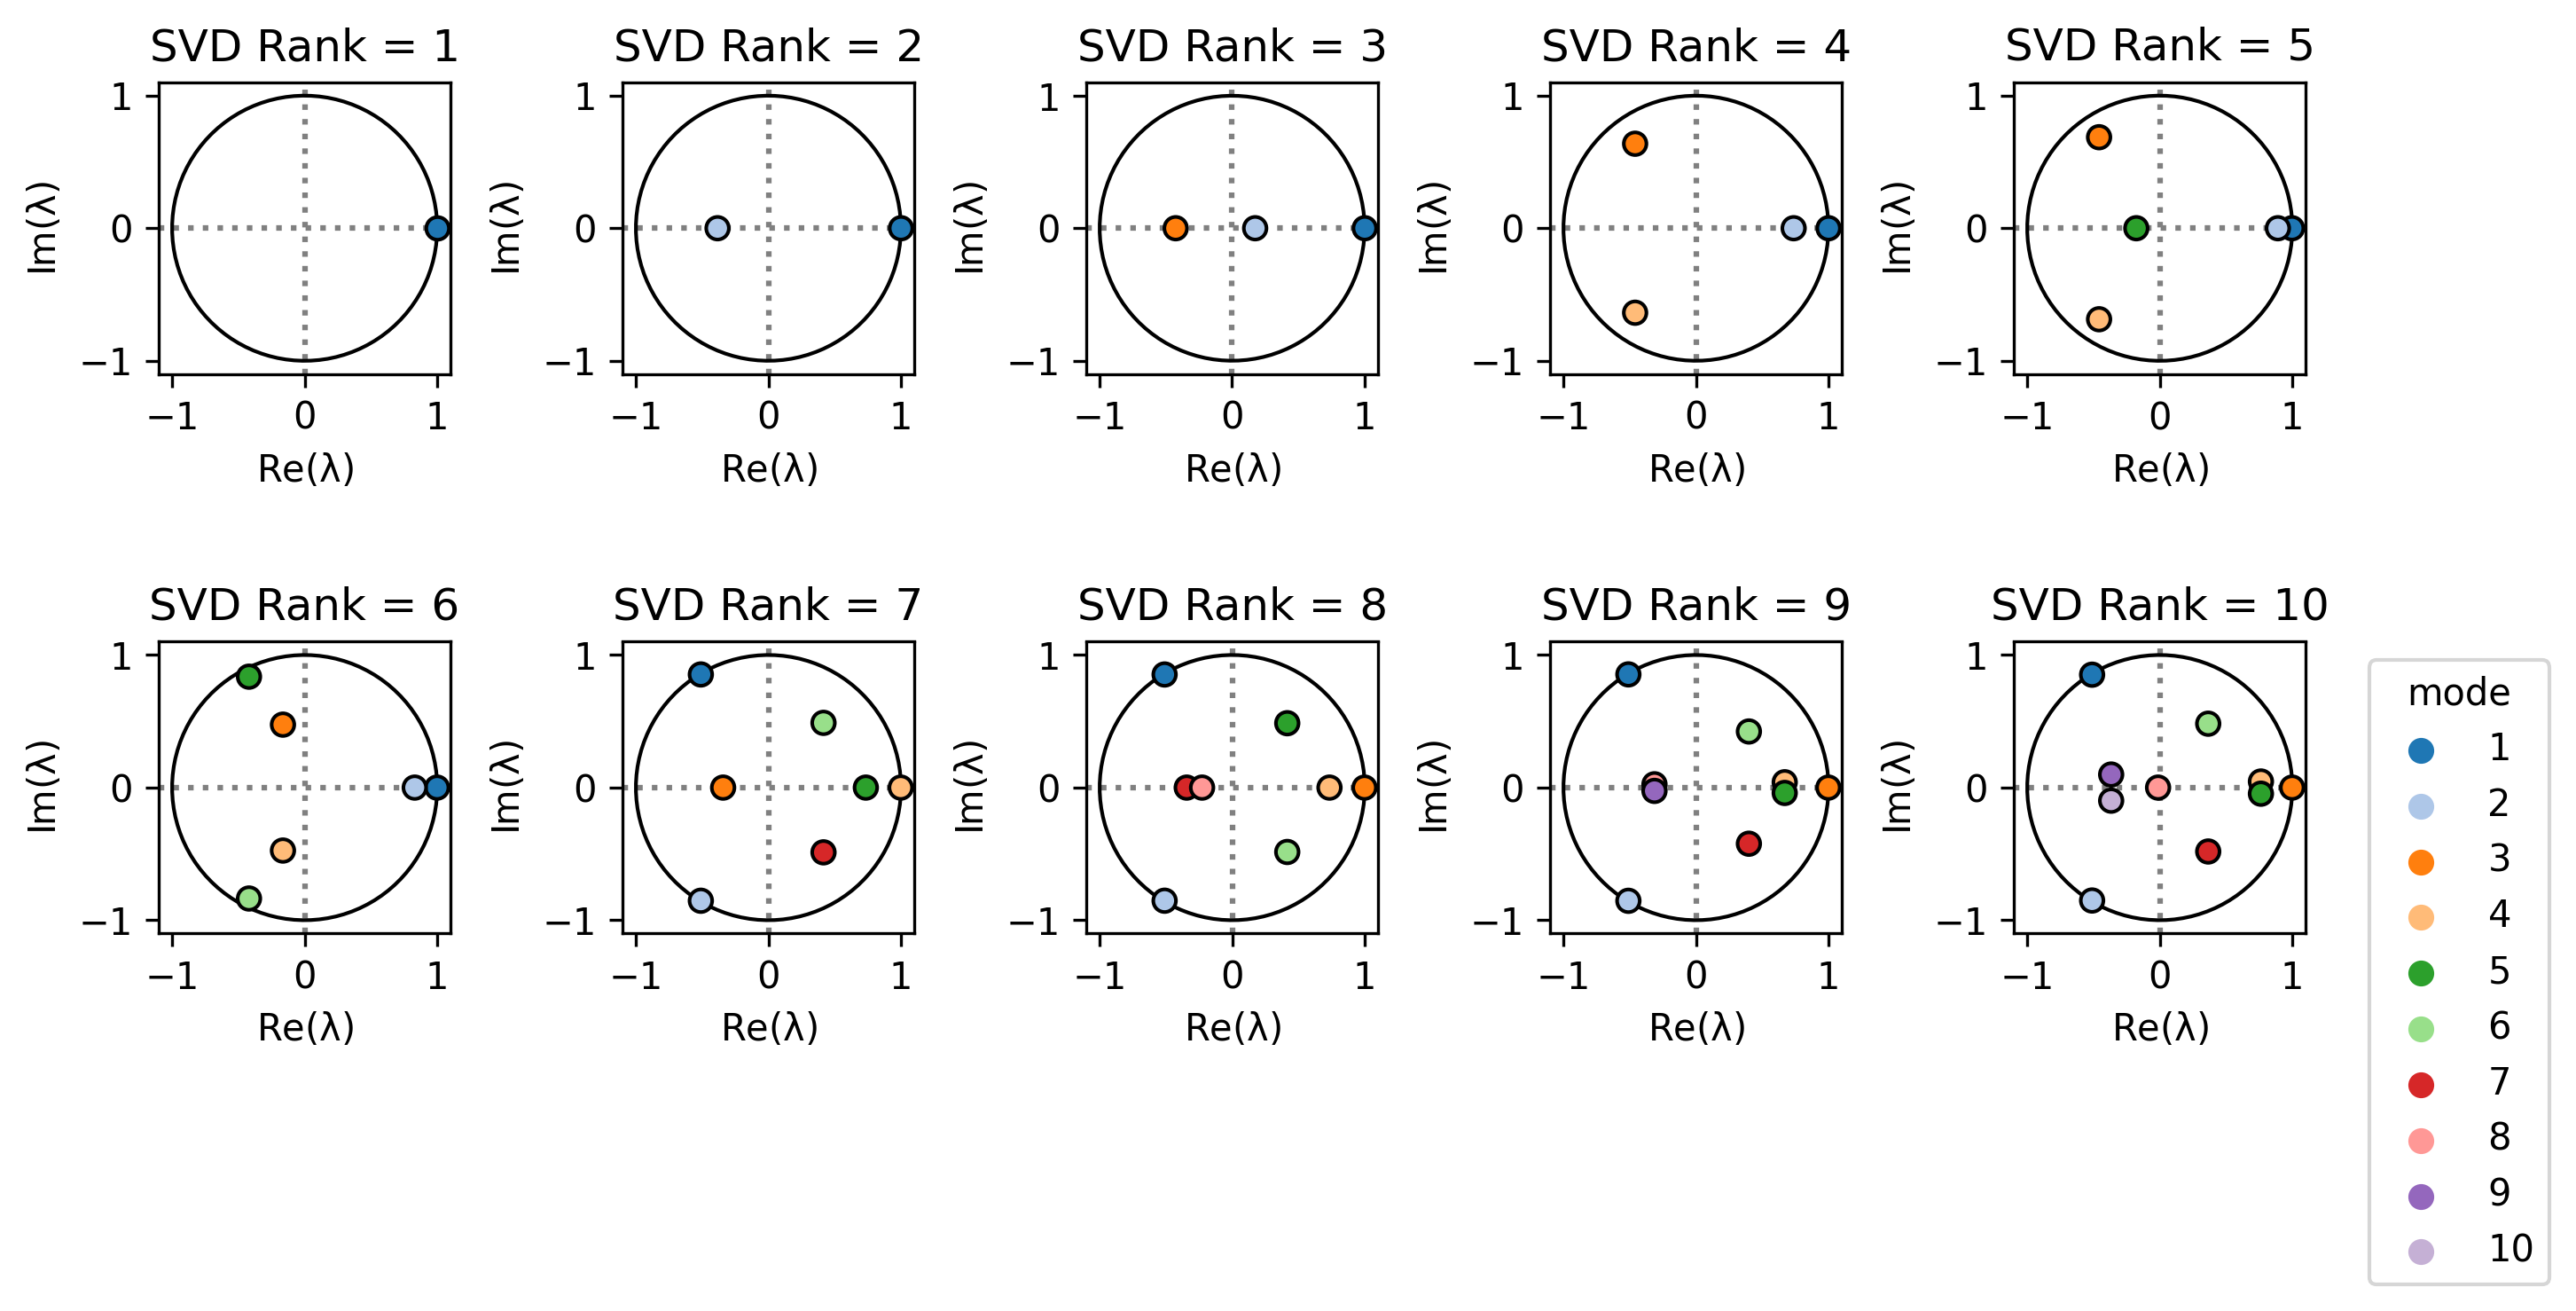

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, (rank, dmd_res) in enumerate(results.items()):

    L = dmd_res['L']

    # make the unit circle
    axs[i].plot(np.cos(np.linspace(0, np.pi*2, 100)), 
                np.sin(np.linspace(0, np.pi*2, 100)), 
                linewidth=1, 
                c='k',
                zorder=1)

    # add the axis
    axs[i].axvline(x=0, ls=":", c='grey', zorder=0)
    axs[i].axhline(y=0, ls=":", c='grey', zorder=0)

    pdf = pd.DataFrame({'real' : np.real(L),
                        'imaginary' : np.imag(L)})
    
    pdf['mode'] = list(range(1, rank+1))

    # plot the eigenvalues
    sns.scatterplot(data=pdf,
                    x='real', 
                    y='imaginary',
                    s=150,
                    marker=".",
                    hue='mode',
                    ec='k',
                    ax=axs[i],
                    palette='tab20',
                    zorder=3)

    axs[i].set_aspect('equal')
    axs[i].set_title(f"SVD Rank = {rank}")
    axs[i].set_xlabel(r'$\mathregular{Re(\lambda)}$')
    axs[i].set_ylabel(r'$\mathregular{Im(\lambda)}$')
    if i == 9:
        sns.move_legend(axs[i],
                        loc='upper right',
                        bbox_to_anchor=(1.9, 1),
                        )
    else:
        axs[i].legend().remove()

# fig.delaxes(axs[14])
plt.tight_layout()

In [12]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 10

# fig, axs = plt.subplots(3, 5, sharey=True, sharex=True)
# axs = axs.ravel()

# for i, (rank, dmd_res) in enumerate(results.items()):

#     L = dmd_res['L']
#     idx = L.argsort()[::-1]   
#     L = L[idx]
    
#     axs[i].plot(L, 
#                 lw=1, 
#                 c='k', 
#                 marker=".")

#     axs[i].axhline(y=0, ls=":", c='grey', zorder=0)
#     axs[i].set_title(f"SVD Rank = {rank}")
#     axs[i].set_xlabel(r'Eigenvalue')
#     axs[i].set_ylabel(r'$\mathregular{Re(\lambda)}$')

# fig.delaxes(axs[14])
# plt.tight_layout()

rank=1 cd=-0.10824948369243548
rank=2 cd=-0.06295039119834867
rank=3 cd=0.23781864142789555
rank=4 cd=0.8197351057220277
rank=5 cd=0.8493781353340184
rank=6 cd=0.9749124875297928
rank=7 cd=0.9989100792122334
rank=8 cd=0.9982540214834358
rank=9 cd=0.9975998611774068
rank=10 cd=0.9979879654039016
     gene      corr      pval  rank
0  A4GALT -0.715835  0.045834     1
1    AAAS -0.086127  0.839309     1
2    AACS -0.852537  0.007156     1
3   AAGAB  0.484885  0.223293     1
4    AAMP -0.766705  0.026449     1


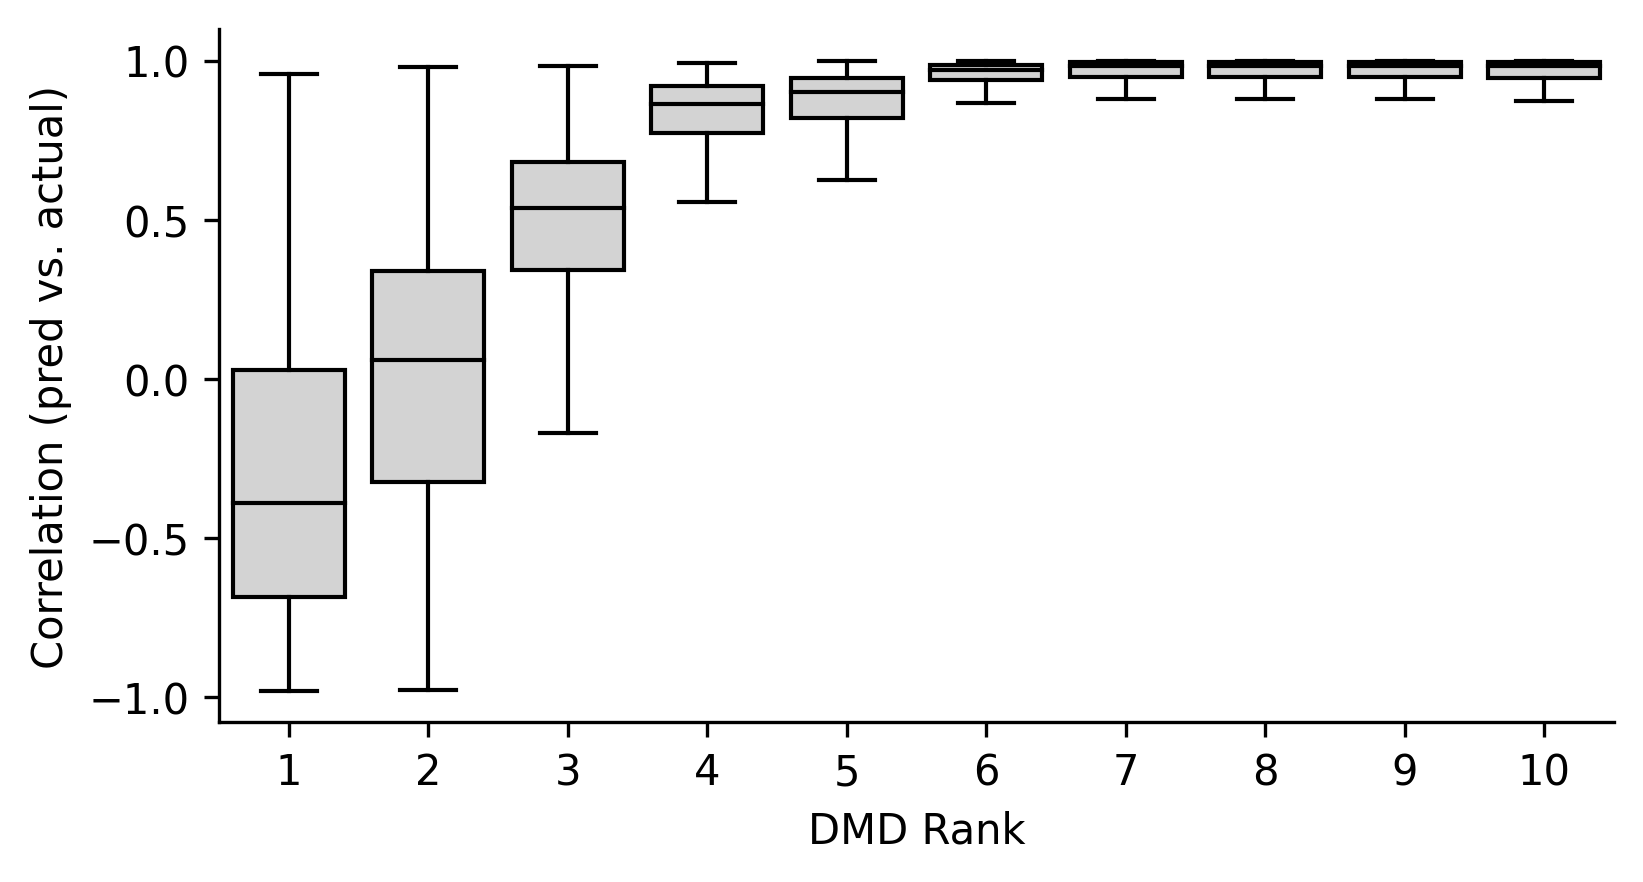

In [13]:
# evaluate the predictive accuracy

gene_labels = pd.DataFrame(high_exp_genes, columns=['gene_name'])

res = []
cd_list = []

for i, (rank, dmd_res) in enumerate(results.items()):
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    print(f"{rank=} {cd=}")
    t_res = hasnain_DMD.sample_correlations(gene_labels, dmd_data, X_pred)

    row = {
        'rank' : rank,
        'cd' : cd,
    }
    cd_list.append(row)
    

    t_res['rank'] = rank
    res.append(t_res)


res = pd.concat(res)
print(res.head())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

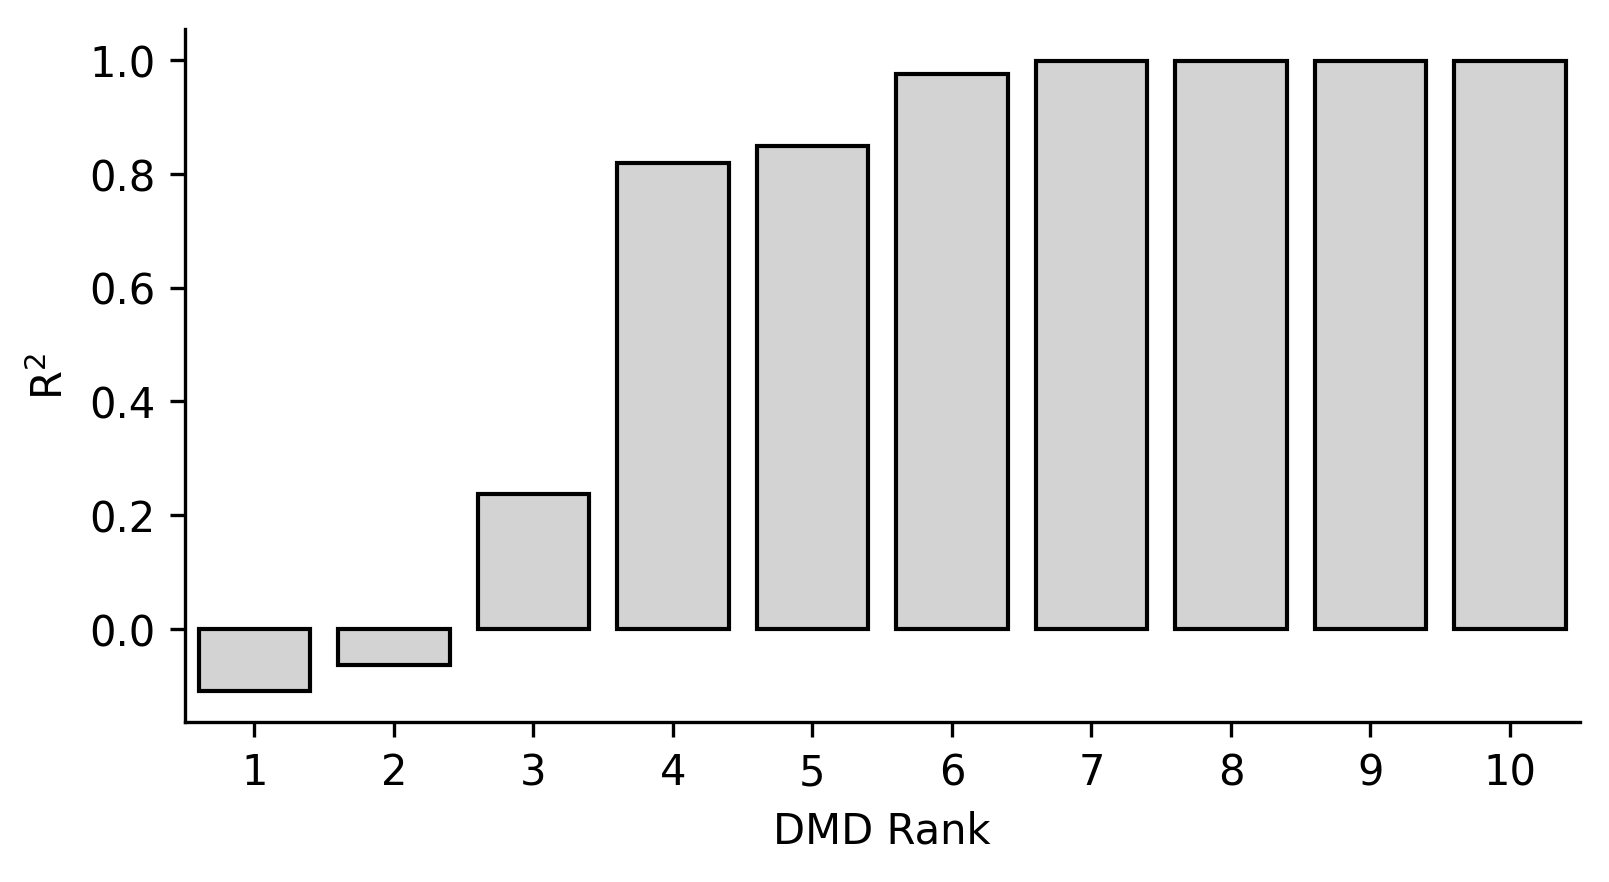

In [14]:
pdf = pd.DataFrame(cd_list)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.barplot(pdf, 
            x='rank',
            y='cd',
            color='lightgrey', 
            ec='k')

plt.ylabel(r"R$^2$")
plt.xlabel("DMD Rank")
sns.despine()

In [15]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Choose Rank = 7; TPM > 5

In [17]:
target = 1e6
threshold = 0.5
# threshold = 1
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dmd_data.shape=(8137, 8, 2)
dmd_res['A'].shape=(8137, 8137)
dmd_res['Atilde'].shape=(7, 7)
dmd_res['u_r'].shape=(8137, 7)
dmd_res['L'].shape=(7,)
dmd_res['W'].shape=(7, 7)
dmd_res['Phi'].shape=(8137, 7)
dmd_res['amplitudes'][0].shape=(7, 8)
done


In [ ]:
# # plot the low-rank dynamics matrix
# Ahat = dmd_res['Atilde']

# print(f"{Ahat.shape=} {Ahat.min()=:.3f} {Ahat.max()=:.3f} {Ahat.mean()=:.3f}")

# nan_count = np.count_nonzero(np.isnan(Ahat))
# print(f"{nan_count=}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 3, 3

# sns.heatmap(Ahat,
#             cmap='viridis',
#             lw=0.1,
#             square=True,
#             cbar_kws={"shrink": 0.5},
#             linecolor='k')

# plt.ylabel("")
# plt.xlabel("")

# plt.xticks([])
# plt.yticks([])
# plt.title(r"$\tilde{\mathbf{A}}$")

np.real(L).max()=0.9981203276507112
pdf.shape=(7, 2)


/home/cstansbu/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


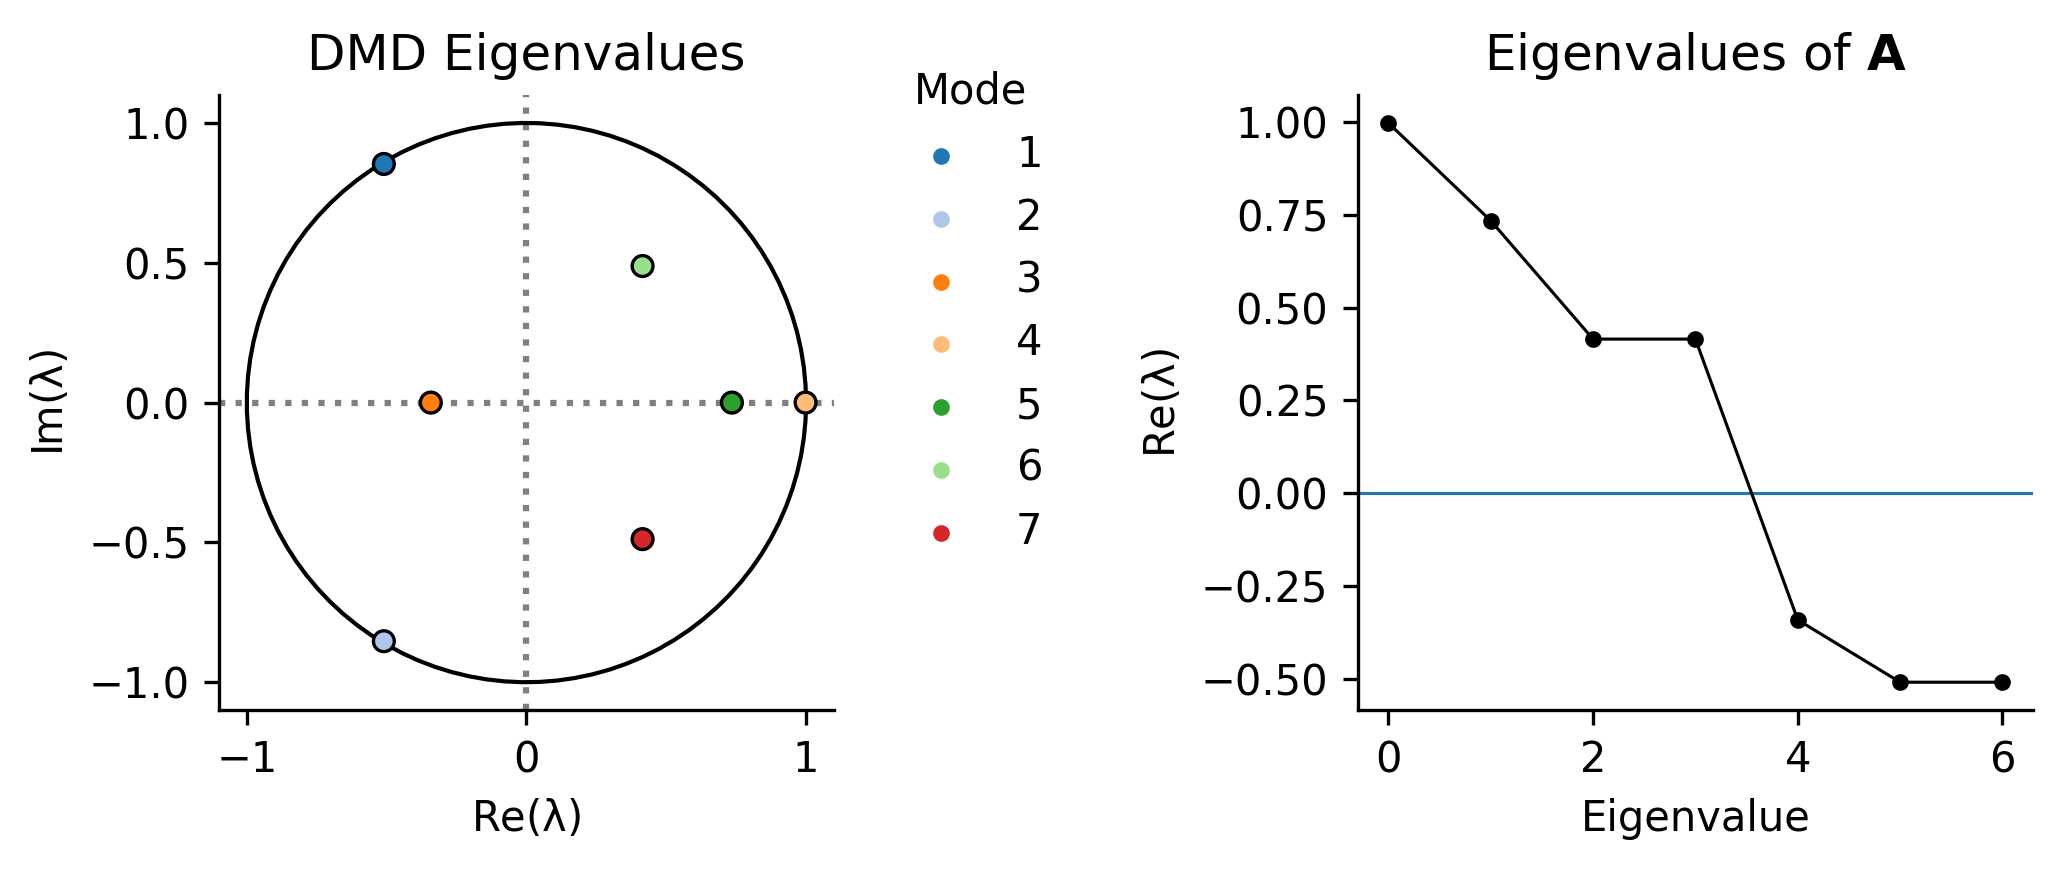

In [18]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)

L = dmd_res['L']

print(f"{np.real(L).max()=}")

# make the unit circle
axs[0].plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot the eigenvalues
sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                ax=axs[0],
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
axs[0].axvline(x=0, ls=":", c='grey', zorder=0)
axs[0].axhline(y=0, ls=":", c='grey', zorder=0)

axs[0].set_aspect('equal')
axs[0].set_title("DMD Eigenvalues")
axs[0].set_xlabel(r'$\mathregular{Re(\lambda)}$')
axs[0].set_ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(axs[0], 
                title='Mode',
                frameon=False, 
                loc='upper right',
                markerscale=0.5,
                bbox_to_anchor=(1.4, 1.1))


axs[1].plot(np.flip(sorted(L)), marker=".", c='k', lw=0.75, zorder=2)
axs[1].axhline(y=0, zorder=1, lw=0.75)
axs[1].set_ylabel(r'$\mathregular{Re(\lambda)}$')
axs[1].set_xlabel("Eigenvalue")
axs[1].set_title(r"Eigenvalues of $\mathbf{A}$")


sns.despine()
plt.tight_layout()

# Visualize predictions

X_pred.shape=(8137, 8, 2) cd=0.9989100792122334


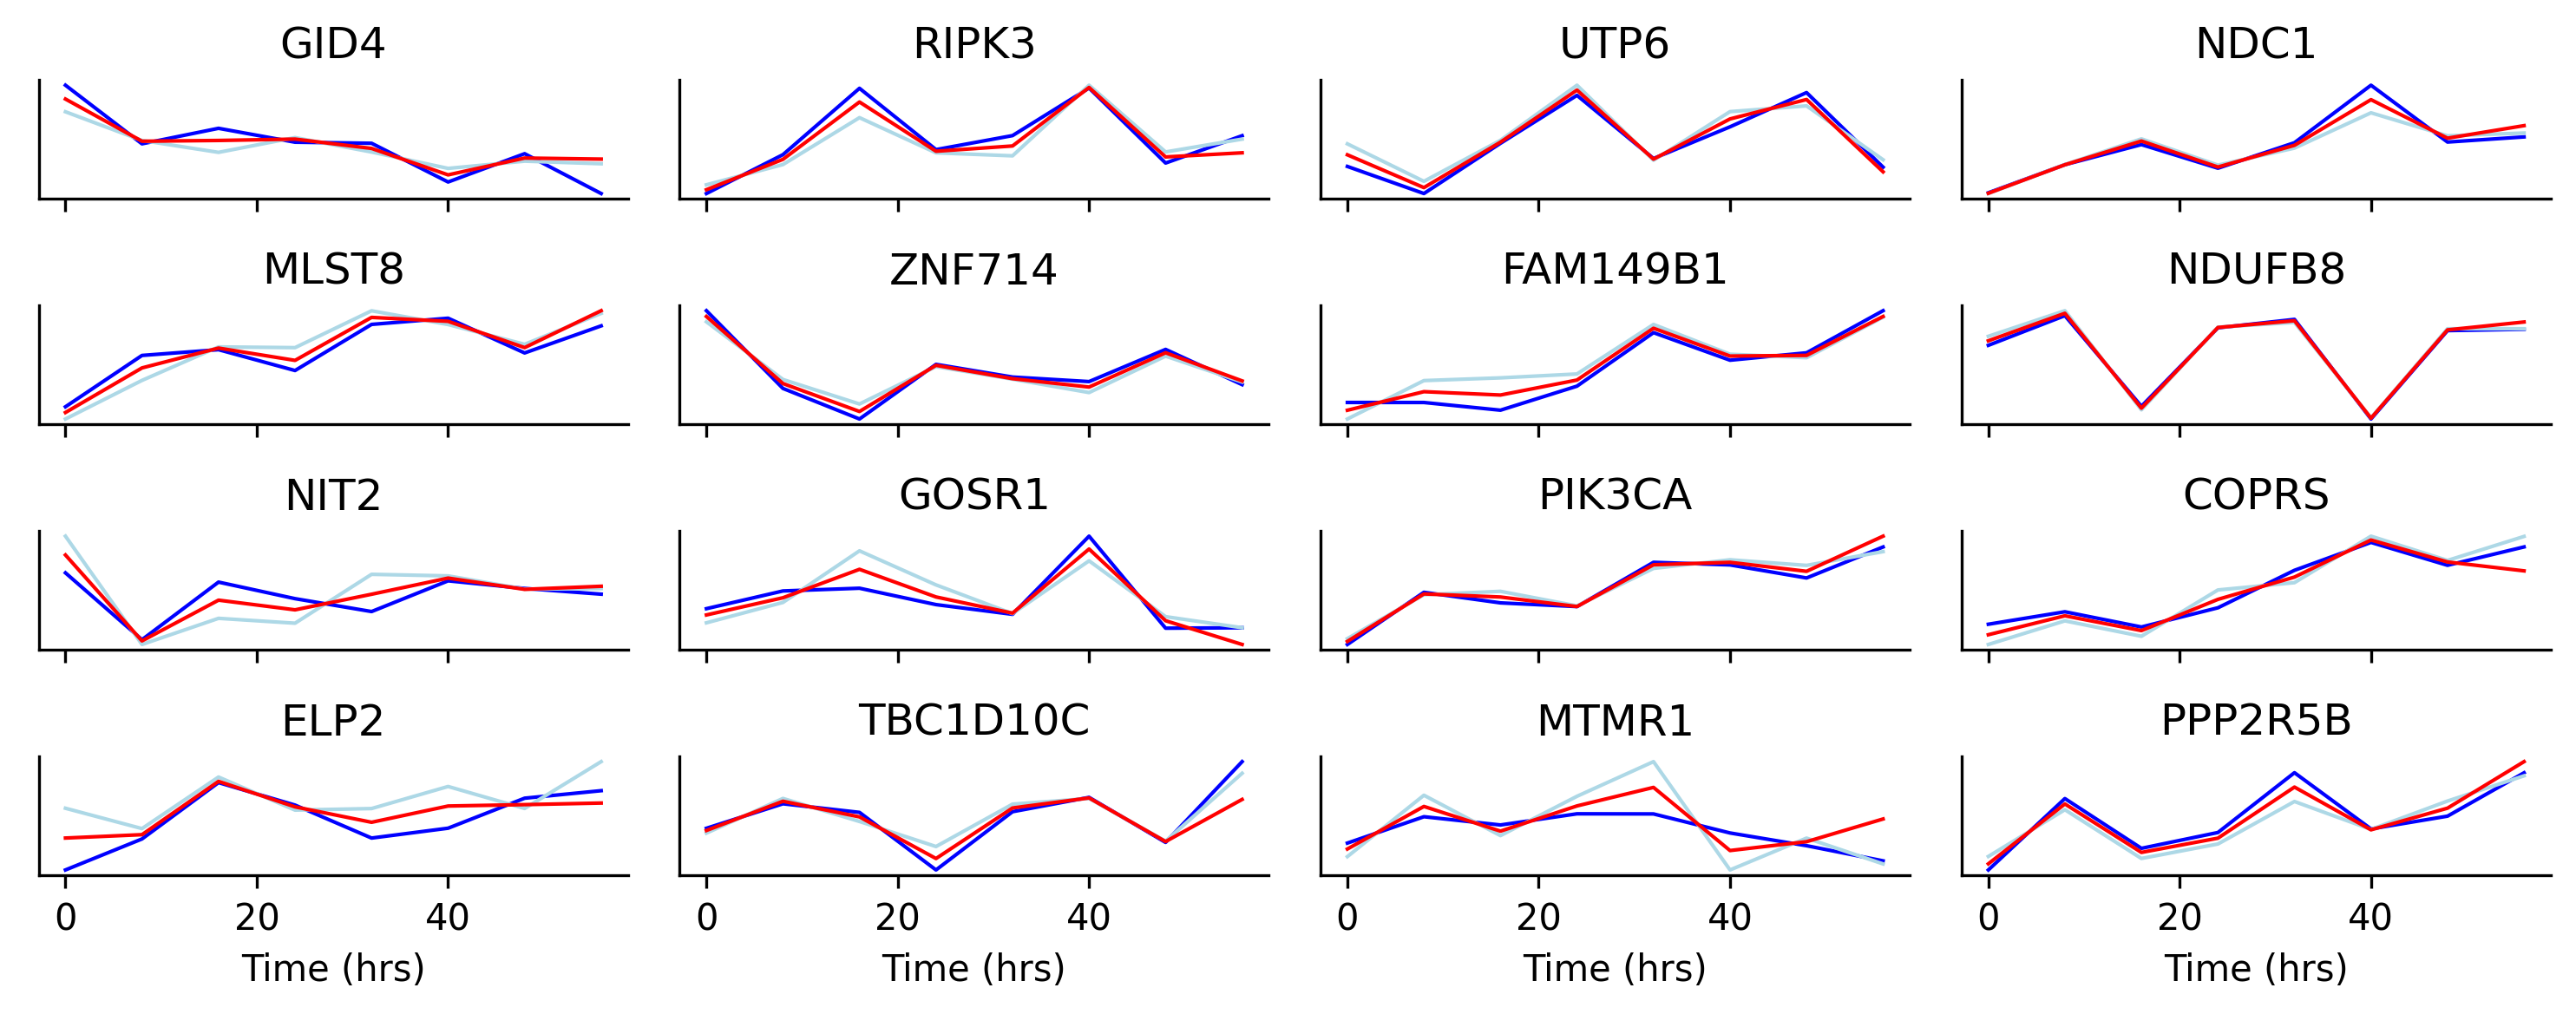

In [19]:
sample_size = 16

gene_labels = pd.DataFrame(high_exp_genes, columns=['gene_name'])
X_pred, cd = hasnain_DMD.get_predictions(dmd_res)

print(f"{X_pred.shape=} {cd=}")

genes = np.random.choice(high_exp_genes, sample_size, replace=False)
gene_ind = [high_exp_genes.index(x) for x in high_exp_genes if x in genes]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4

fig, axs =  plt.subplots(4, 4, sharex=True)
axs = axs.ravel()

for i, ind in enumerate(gene_ind):
    gene_name = genes[i]

    pdf = pd.DataFrame(dmd_data[ind, :, :], columns=['r1', 'r2'])
    pdf['pred'] = X_pred[ind, :, :].mean(axis=1)
    # pdf['pred'] = savgol_filter(pdf['pred'], 5, 3)

    pdf = pdf.reset_index(drop=False)
    pdf['hours'] = pdf['index'] * 8
    pdf = pdf.drop(columns='index')
    pdf = pd.melt(pdf, id_vars=['hours'])

    sns.lineplot(pdf,
                 x='hours',
                 y='value',
                 hue='variable',
                 lw=1,
                 legend=False,
                 palette=['blue', 'lightblue','r'],
                 ax=axs[i])

    axs[i].set_ylabel("")
    axs[i].set_yticks([])
    axs[i].set_xlabel("Time (hrs)")
    axs[i].set_title(gene_name)


plt.tight_layout()
sns.despine()


# Top Genes for Each Mode

phi.shape=(8137, 7)


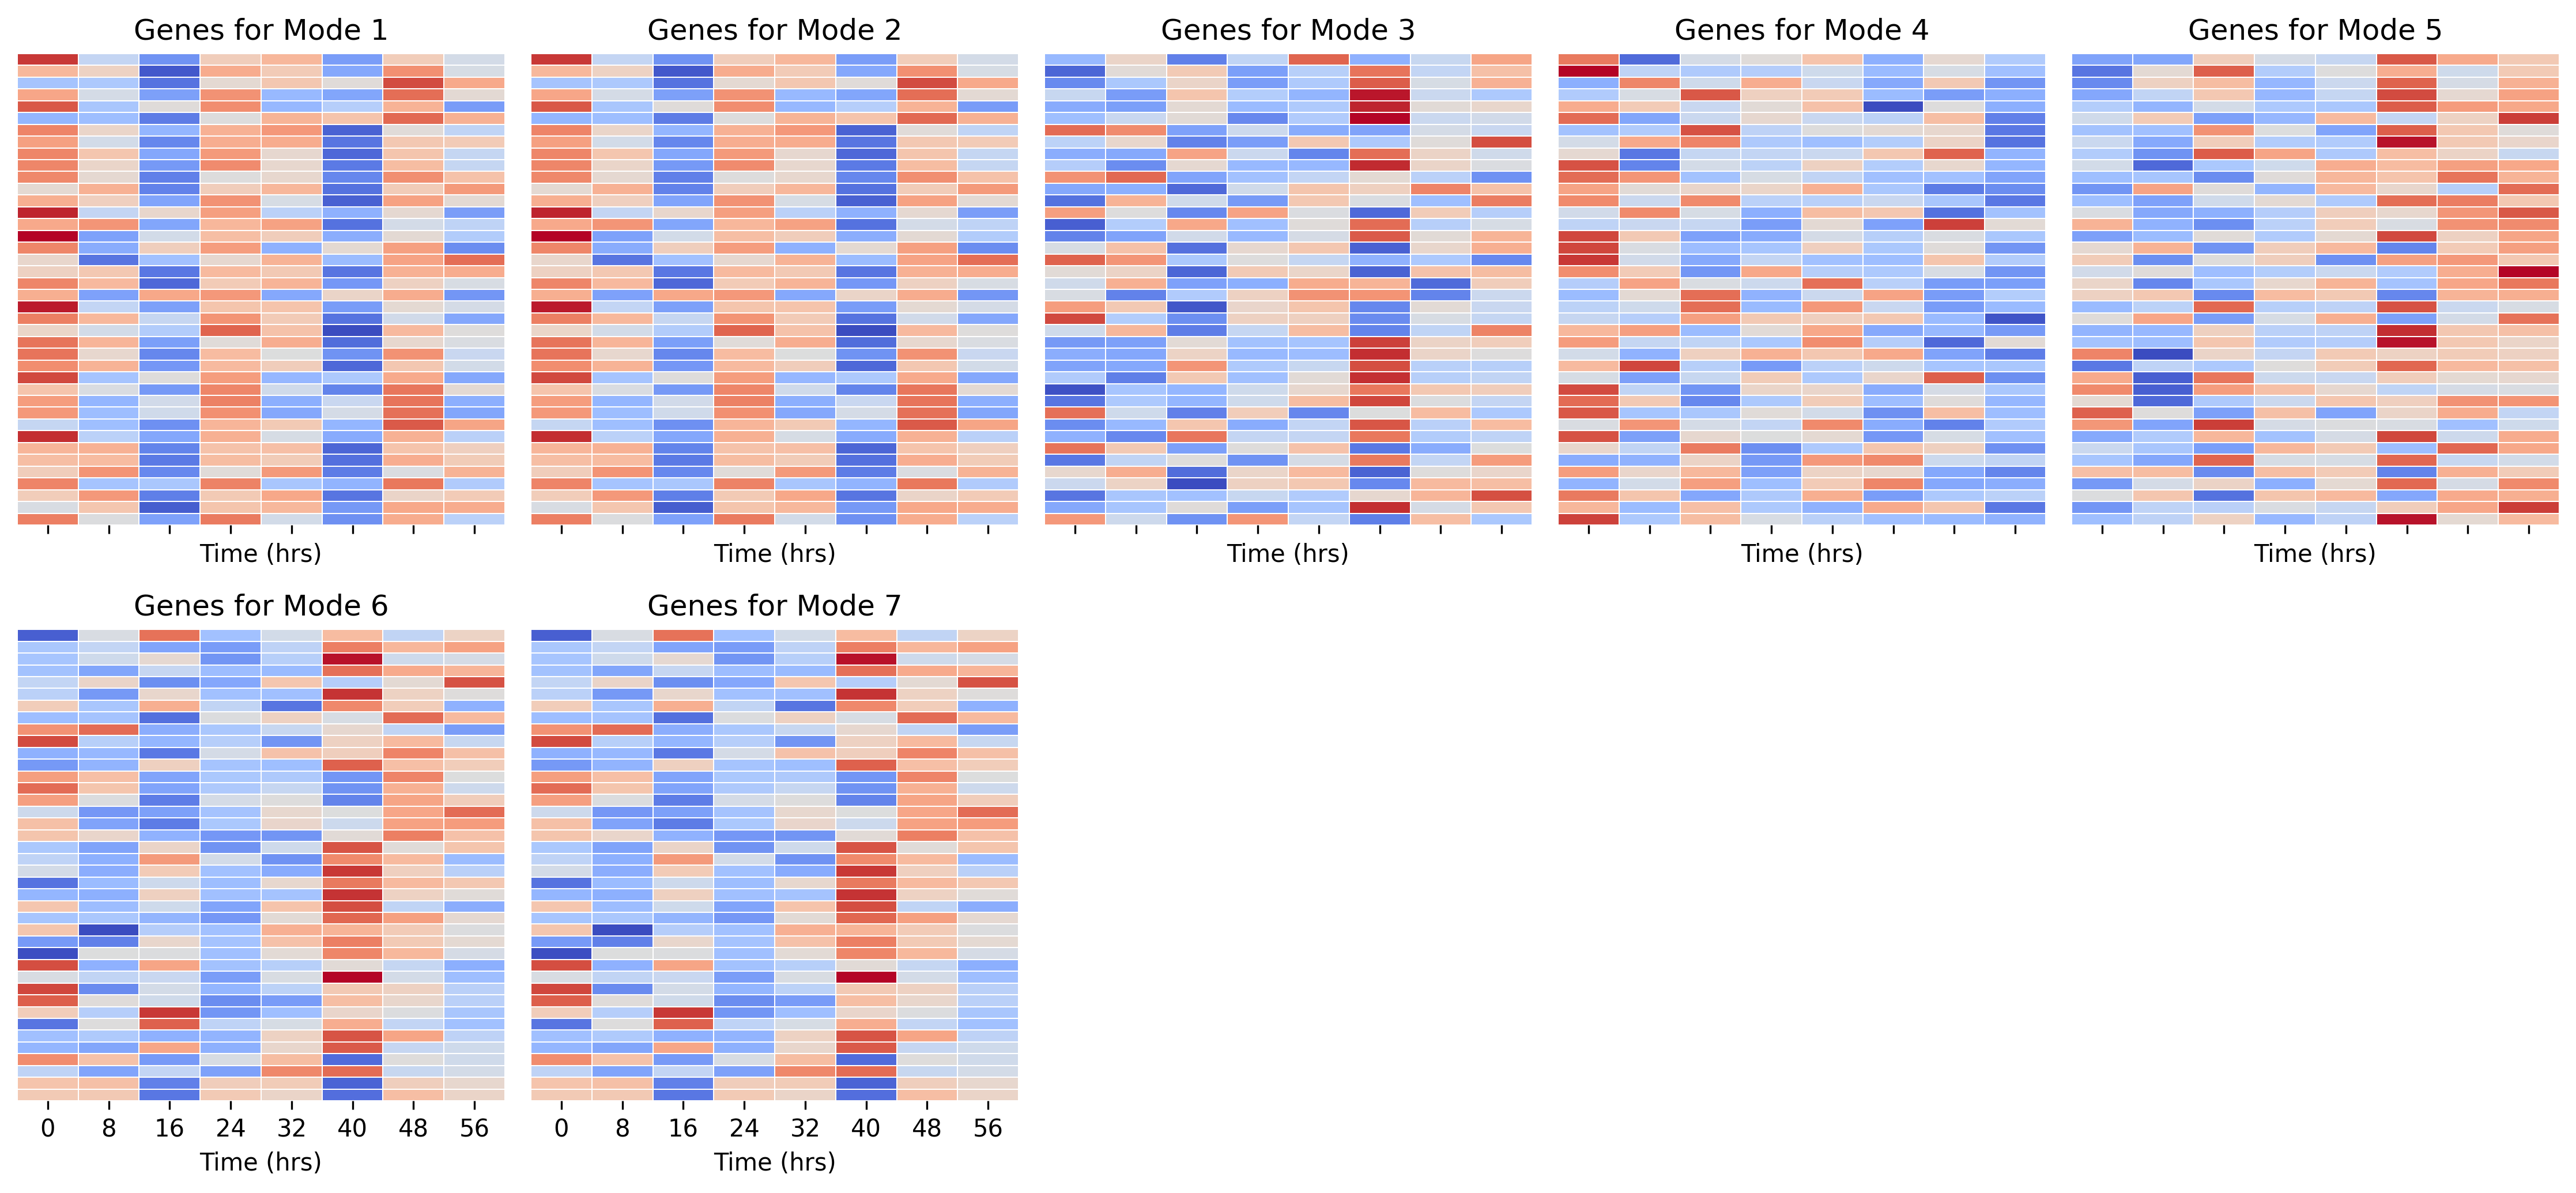

In [20]:
top_n = 40

# get the normalized expression data
pdf = d.copy()
pdf = pdf.reset_index(drop=False)
pdf = nb.meltDf(pdf)
pdf = pdf[pdf['control'] != 'control']

# get the top genes for each mode
phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 7

fig, axs = plt.subplots(2, 5, sharex=True)
axs = axs.ravel()

for i, _mode in enumerate(phi.columns):

    # get top genes for each mode
    top_genes = phi[phi[_mode] <= top_n][_mode].index.to_list()

    # get the normalized expression of those genes
    tmp = pdf[pdf['geneName'].isin(top_genes)]
    tmp = pd.pivot_table(tmp, 
                         index='geneName', 
                         columns='hours',
                         values='value',
                         aggfunc='mean')

    # standardize over time
    scaler = StandardScaler()
    mat_norm = scaler.fit_transform(tmp.T).T
    mat_norm = pd.DataFrame(mat_norm, 
                            index=tmp.index, 
                            columns=tmp.columns)

    sns.heatmap(mat_norm,
                ax=axs[i],
                cbar=False,
                # vmin=-3,
                # vmax=3,
                cmap='coolwarm',
                lw=0.1,)

    axs[i].set_xlabel("Time (hrs)")
    axs[i].set_ylabel("")
    axs[i].set_yticks([])
    axs[i].set_title(f"Genes for Mode {_mode+1}")

fig.delaxes(axs[7])
fig.delaxes(axs[8])
fig.delaxes(axs[9])
plt.tight_layout()

In [ ]:
ut.makeColorbar('coolwarm', 0.2, 2.5, 'Expression', 'vertical', ['Low', 'High'])

# Explore the top genes for each mode

In [21]:
top_n = 200
alpha = 0.05

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = []


for c in phi.columns:
    genes = phi[phi[c] <= top_n][c].index.to_list()
    
    enrich = gget.enrichr(genes, database=db)
    enrich = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
    enrich = enrich[enrich['adj_p_val'] <= alpha]
    enrich['mode'] = c + 1
    pd.set_option('display.max_colwidth', 100)

    print(f"======== Mode {c+1} ========")
    print(enrich[['path_name', 'adj_p_val']].head(10))

    edf.append(enrich)
    print()
    time.sleep(1)

    
    # break

edf = pd.concat(edf)
# edf.to_csv("mode_genes.csv")
print('done')

Mon Oct 30 14:17:31 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


phi.shape=(8137, 7)
======== Mode 1 ========
                                                        path_name  \
0                              DNA metabolic process (GO:0006259)   
1                       protein-DNA complex assembly (GO:0065004)   
2               mitotic sister chromatid segregation (GO:0000070)   
3                            nucleosome organization (GO:0034728)   
4                            chromosome condensation (GO:0030261)   
5                      DNA-dependent DNA replication (GO:0006261)   
6  regulation of mitotic cell cycle phase transition (GO:1901990)   
7                       sister chromatid segregation (GO:0000819)   
8             mitochondrial translational elongation (GO:0070125)   
9                                 chromatin assembly (GO:0031497)   

      adj_p_val  
0  1.024362e-09  
1  1.139467e-08  
2  1.499693e-08  
3  6.495008e-08  
4  1.491470e-07  
5  1.491470e-07  
6  1.605473e-07  
7  2.421123e-07  
8  2.421123e-07  
9  4.126363e-07

Mon Oct 30 14:17:33 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 2 ========
                                                        path_name  \
0                              DNA metabolic process (GO:0006259)   
1                       protein-DNA complex assembly (GO:0065004)   
2               mitotic sister chromatid segregation (GO:0000070)   
3                            nucleosome organization (GO:0034728)   
4                            chromosome condensation (GO:0030261)   
5                      DNA-dependent DNA replication (GO:0006261)   
6  regulation of mitotic cell cycle phase transition (GO:1901990)   
7                       sister chromatid segregation (GO:0000819)   
8             mitochondrial translational elongation (GO:0070125)   
9                                 chromatin assembly (GO:0031497)   

      adj_p_val  
0  1.024362e-09  
1  1.139467e-08  
2  1.499693e-08  
3  6.495008e-08  
4  1.491470e-07  
5  1.491470e-07  
6  1.605473e-07  
7  2.421123e-07  
8  2.421123e-07  
9  4.126363e-07  



Mon Oct 30 14:17:34 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 3 ========
                                                                          path_name  \
0                                              cytoplasmic translation (GO:0002181)   
1          SRP-dependent cotranslational protein targeting to membrane (GO:0006614)   
2                        cotranslational protein targeting to membrane (GO:0006613)   
3                                              protein targeting to ER (GO:0045047)   
4  nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)   
5                                                          translation (GO:0006412)   
6                           nuclear-transcribed mRNA catabolic process (GO:0000956)   
7                                         peptide biosynthetic process (GO:0043043)   
8                          cellular macromolecule biosynthetic process (GO:0034645)   
9                                                      gene expression (GO:0010467)   

      adj_p_val  

Mon Oct 30 14:17:36 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 4 ========
Empty DataFrame
Columns: [path_name, adj_p_val]
Index: []



Mon Oct 30 14:17:38 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 5 ========
                                                                                             path_name  \
0                                                     cytokine-mediated signaling pathway (GO:0019221)   
1  antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independen...   
2                                                  cellular response to type I interferon (GO:0071357)   
3                                                     type I interferon signaling pathway (GO:0060337)   
4                                             interferon-gamma-mediated signaling pathway (GO:0060333)   
5                                                   cellular response to interferon-gamma (GO:0071346)   
6  antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway...   
7  antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway...   
8                    

Mon Oct 30 14:17:40 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 6 ========
                                                                          path_name  \
0          SRP-dependent cotranslational protein targeting to membrane (GO:0006614)   
1                                              cytoplasmic translation (GO:0002181)   
2                        cotranslational protein targeting to membrane (GO:0006613)   
3                                              protein targeting to ER (GO:0045047)   
4  nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)   
5                           nuclear-transcribed mRNA catabolic process (GO:0000956)   
6                                                          translation (GO:0006412)   
7                                         peptide biosynthetic process (GO:0043043)   
8                          cellular macromolecule biosynthetic process (GO:0034645)   
9                                                      gene expression (GO:0010467)   

      adj_p_val  

Mon Oct 30 14:17:42 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 7 ========
                                                                          path_name  \
0          SRP-dependent cotranslational protein targeting to membrane (GO:0006614)   
1                                              cytoplasmic translation (GO:0002181)   
2                        cotranslational protein targeting to membrane (GO:0006613)   
3                                              protein targeting to ER (GO:0045047)   
4  nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)   
5                           nuclear-transcribed mRNA catabolic process (GO:0000956)   
6                                                          translation (GO:0006412)   
7                                         peptide biosynthetic process (GO:0043043)   
8                          cellular macromolecule biosynthetic process (GO:0034645)   
9                                                      gene expression (GO:0010467)   

      adj_p_val  

pdf.shape=(494, 7)


Text(0.5, 44.16666666666663, 'Mode')

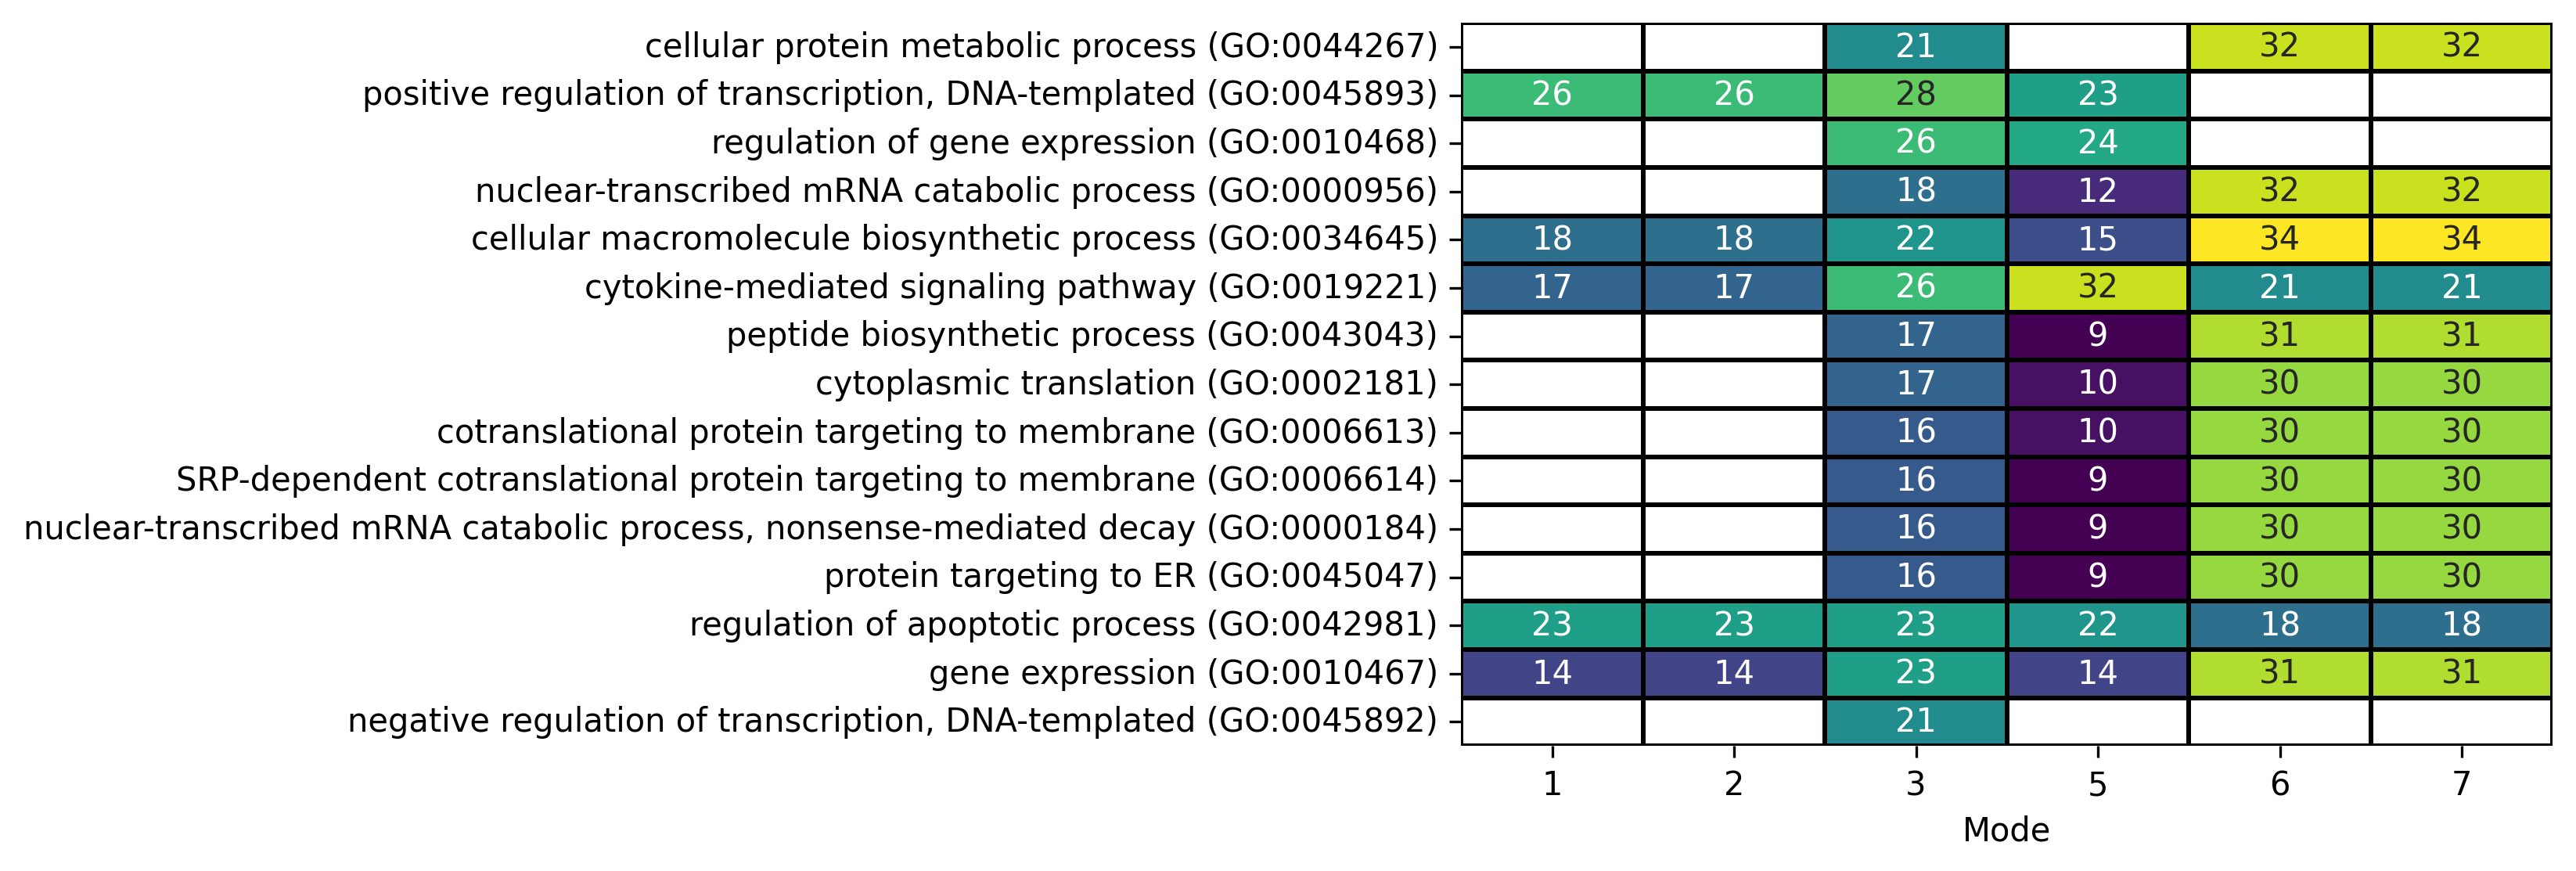

In [22]:
alpha = 0.05
n_plot = 15

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))

pdf = pd.pivot_table(pdf, 
                     index='path_name',
                     columns='mode',
                     values='n_gene')

mode_columns = pdf.columns
pdf['row_sum'] = pdf.mean(axis=1)
pdf = pdf.sort_values(by='row_sum', ascending=False)

print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4

sns.heatmap(pdf[mode_columns].head(n_plot),
            lw=1,
            linecolor='k',
            annot=True,
            cbar=False,
            cmap='viridis')

plt.ylabel("")
plt.xlabel("Mode")

In [ ]:
break

# Obersevability

In [ ]:
# the quick gramian

nT = 10

A = dmd_res['A']
u = dmd_res['u_r']
x0_embedded = dmd_res['data_embedded'][:,0,:]
x0 = np.dot(u, x0_embedded)

print(f"{A.shape=} {x0.shape=} {x0_embedded.shape=} {u.shape=}")

nan_count = np.count_nonzero(np.isnan(A))
print(f"{nan_count=}")


A = np.nan_to_num(A.copy() ,0)

G_list =[]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

fig, axs = plt.subplots(2, 5, sharex=True)
axs = axs.ravel()

for i, t in enumerate(range(nT)):
    Aexp = np.linalg.matrix_power(A, t)
    G = np.linalg.multi_dot([Aexp, x0, x0.T, Aexp.T])
    G_list.append(G)
    print(f"{G.shape=}")

    axs[i].matshow(G)
    # axs[i].set_xticks([])
    # axs[i].set_yticks([])
    
    # break

In [ ]:
high_exp_genes[np.argmax(x0[:,0])]

In [ ]:
print(f"{x0.shape=}")
test = np.dot(x0, x0.T)

print(f"{x0.shape=} {test.shape=}")
nan_count = np.count_nonzero(np.isnan(test))
print(f"{nan_count=}")

plt.matshow(test[0:100, 0:100])

In [ ]:
A = dmd_res['A']
u = dmd_res['u_r']
x0_embedded = dmd_res['data_embedded'][:,0,:]
x0 = np.dot(u, x0_embedded)

print(f"{A.shape=} {x0.shape=} {x0_embedded.shape=} {u.shape=}")
nT = 6
G = hasnain_DMD.gram_matrix(A, x0, nT=nT, reduced=False)
print(f"{G.shape=}")

In [ ]:
# break

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

n_val = 10
evals = D[:n_val]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{G}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [ ]:
break

In [ ]:
obs = pd.DataFrame({'gene' : high_exp_genes,
                    'ev1' : V[:,0],
                    'weight' : np.real(V[:,0])})

obs['rank'] = obs['weight'].rank()
obs = obs.sort_values(by='rank', ascending=False)

obs.head(10)

In [ ]:
# obs['gene'].head(10).to_list()

In [ ]:
# obs.tail(20)

In [ ]:
# fpath = "2015.obs.ranking.csv"
# obs.to_csv(fpath, index=False)

In [ ]:
n_gene = 200
# genes = obs['gene'].head(n_gene).to_list()
genes = obs['gene'].tail(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

In [ ]:
# alpha = 0.01
# edf = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
# edf = edf[edf['adj_p_val'] <= alpha]

# fapth = "top_200_observable_GSEA.csv"
# edf.to_csv(fapth, index=False)

In [ ]:
kid = "hsa04110"
pway_genes = ut.parseKEGG(kid)
len(pway_genes)

In [ ]:
top = 500
observables = obs['gene'].head(top).to_list()
hits = [x for x in observables if x in pway_genes]
print(len(hits))

# State estimation

In [ ]:
## state estimation
rep = 0
t = 7 # not including the initial condition
x0 = dmd_data[:, 0, rep]
A = dmd_res['A']

Kt = []

for i in np.arange(0, t):
    print(f"Computing A^{i}...")
    At = np.linalg.matrix_power(A, i)
    Kt.append(At)

print('done')

In [ ]:
def select_sensors(V, n_sensors=10):
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]
    return w
    

def reconstruct_x0(data,nT,A,C):
    '''
    The matrix C should be of shape (pxn) if the data are shape (nxm) for p measured genes, n total genes, and m samples
    If p << n, leave only entries of C that correspond to the p genes as nonzero.
    '''
    # generate outputs at nT timepoints, check rank of O_T, and estimate IC
    O_T = np.zeros((len(C)*nT,C.shape[1])) # O_T has dim p*nT x n
    for ii in range(O_T.shape[0]): # observability matrix
        O_T[ii] = C @ np.linalg.matrix_power(A,ii)    

    # use the learned dynamics and sampling to generate output over time
    y = np.zeros((len(C),nT)) 
    for ii in range(nT):
        y[:,ii] = C @ np.linalg.matrix_power(A,ii) @ data[:,0]

    # estimate of x0 
    x0_est = np.linalg.pinv(O_T) @ y.T

    return x0_est


n_sensors = 10
C = select_sensors(V, n_sensors=10)
C = np.expand_dims(C, axis=0)
nT = 3
data = dmd_data[:, :, 0]
x0 = dmd_data[:, 0, 0]
A = dmd_res['A']

z0 = reconstruct_x0(data, nT, A, C)

l2 = np.linalg.norm(z0 - x0)
score, pval = scipy.stats.pearsonr(np.squeeze(z0), x0)
print(f"{n_sensors=} {nT=} {l2=} {score=} {pval=}")

n_sensors=10 nT=2 l2=26523.348000151007 score=0.40856815914052497 pval=0.0

In [ ]:
""" Build the observed data matrix: need to only index the sensors, or all?"""

def estimate_z0(n_sensors, nT, Kt, data, V):
    """A function to estimate the initial condition given:
        : n_sensors (int) the number of top sensors to select, given the principal eigenvector of the Gram matrix
        : nT (int): number of timepoints for which to construct the estimation. Bounded the len(Kt).
        : Kt (list of gene x gene array): The precomputed exponentiation of the learned dynamics from DMD 
        : data (gene x time): the original data for a single replicate
        : V : the eigenvectors of the Gram matrix (columns are eigenvectors)
    """
    # get the gene sampling wieghts and select sensors
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]

    # compute the measurements and the esitmated dynamics, given the 
    # selected sensors
    # outputs
    yt = []
    O = []
    for i in np.arange(0, nT):
        print(i)
        yt.append( np.dot(w, data[:, i]))
    
        if i == 0:
            O.append(w)
        else:
            wKt = np.dot(w, Kt[i])
            O.append(wKt)

    yt = np.asarray(yt)
    O = np.asarray(O)
    print(f"{yt.shape=} {O.shape=}")
    z0 = np.dot(np.linalg.pinv(O), yt)
    return z0
    
n_sensors = 10
nT = 10
data = dmd_data[:, :, 1]
z0 = estimate_z0(n_sensors, nT, Kt, data, V)

np.linalg.norm(z0 - x0)

In [ ]:
nT = 4
data = dmd_data[:, :, 0]

res = []

for n_sensors in np.arange(10, 1000, step=100):
    z0 = estimate_z0(n_sensors, nT, Kt, data, V)
    score, pval = scipy.stats.pearsonr(z0, x0)
    l2 = np.linalg.norm((z0-x0))
    row = {
        'n_sensors' : n_sensors,
        'corr' : score,
        'pval' : pval,
        'norm' : l2,
    }
    res.append(row)
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.lineplot(data=res, 
              x='n_sensors',
              y='norm')

plt.ylabel(r"$||\hat{x}_0 - x_0||_2$")
plt.xlabel("Number of Sensors")
plt.show()

sns.lineplot(data=res, 
              x='n_sensors',
              y='corr')

plt.ylabel(r"corr$(\hat{x}_0, x_0)$")
plt.xlabel("Number of Sensors")
plt.show()

res.head()

In [ ]:
break

In [ ]:
# get the sensors
w = np.real(V[:,0])
ind = np.argpartition(w, -n_sensors)[-n_sensors:]
w_bin = np.zeros(w.shape)
w_bin[ind] = w[ind]

print(np.asarray(gene_names)[ind])

yt_true = dmd_data[:, t-1, rep] # t-1 for index offset
A = dmd_res['A']

print(f"{A.shape=} {x0.shape=} {w.shape=} {yt_true.shape=}")

At = np.linalg.matrix_power(A, t)
print(f"{At.shape=}")

In [ ]:
# get the sensors
n_sensors = 100
w = np.real(V[:,0:n_sensors])
C = np.zeros(w.shape)

row_ind = np.argpartition(w[:, 0], -n_sensors)[-n_sensors:] # leading eigenvector
col_ind = np.arange(0, n_sensors)

C[row_ind, col_ind] = 1
print(f"{C.shape=} {C.sum()=}")

yt_pred = np.dot(C.T, np.dot(At, x0))
print(f"{yt_pred.shape=} {yt_true.shape=} {yt_true[row_ind].shape=}")

# print()
# print(yt_true[ind])
# print()
# print(yt_pred)
# print()

np.corrcoef(yt_true[row_ind], yt_pred)


In [ ]:
np.corrcoef(yt_true[ind], test)

In [ ]:
test